In [176]:
# Import packages
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
import date_to_unix as date
import datetime
import itertools
import numpy as np

In [177]:
# Load data
data = pd.read_csv('/Users/nikopindao/Desktop/Master /MA2/Blockchain /Project/Carry_Trade/data/Bitcoin 2019-09-10')
data['Open Time'] = pd.to_datetime(data['Open Time'])  # Convert before setting as index
data.set_index('Open Time', inplace=True, drop=True)
data

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate
Open Time,,,,,
2019-09-10 08:00:00,10272.64,10271.93,0.000100,NaN,0.000100
2019-09-10 16:00:00,10176.26,10172.13,0.000100,NaN,0.000200
2019-09-11 00:00:00,10098.19,10094.27,0.000100,NaN,0.000300
2019-09-11 08:00:00,10066.38,10068.41,0.000100,NaN,0.000400
2019-09-11 16:00:00,9990.57,9992.18,0.000100,NaN,0.000500
...,...,...,...,...,...
2024-05-14 00:00:00,62940.09,62912.20,0.000099,62917.600000,0.688804
2024-05-14 08:00:00,62035.39,62002.00,0.000100,62003.151865,0.688904
2024-05-14 16:00:00,61787.60,61750.00,0.000044,61749.900000,0.688948


In [178]:
def Strategy(data, X, fees_future, fees_spot, threshold):
    # Original fraction of BTCUSDT held as perp and spot
    fract_perp = (X / data['Open BTCUSDT_PERP'][0])
    fract_spot = (X / data['Open BTCUSDT_SPOT'][0])

    # Compute initial fees from the first position and substract later to the first result
    initial_fees = -(X * fees_future + X * fees_spot)

    # Initialize variables
    position_open = True
    last_open_index = 0
    result = []
    PandL = []
    size_final_f = []
    size_final_s = []

    # Iterate through the data
    for i in range(len(data)):

        if position_open:
            
            # Closing condition for the position: 
            # verify if the cost of keeping the position open is greater than the threshold (which is an approximation of the cost of closing the position and reopening it at the same time)
            if data['fundingRate'].iloc[i] < 0 and abs(data['fundingRate'].iloc[i] * fract_perp) > threshold:
                # Close the position
                position_open = False
                # Compute the fees for closing the position
                result.append(-(X * fees_future + X * fees_spot))
                # Compute the P&L for closing the position
                PandL.append((fract_perp * (- data['Open BTCUSDT_PERP'].iloc[i] + data['Open BTCUSDT_PERP'].iloc[last_open_index])) +
                             (fract_spot * (data['Open BTCUSDT_SPOT'].iloc[i] - data['Open BTCUSDT_SPOT'].iloc[last_open_index])))
                X += ((PandL[-1] + sum(result[last_open_index:i]))/2)
                size_final_f.append(0)
                size_final_s.append(0)

            else:

                # Keep the position open
                position_open = True
                result.append(X * data['fundingRate'].iloc[i])
                PandL.append((fract_perp * (- data['Open BTCUSDT_PERP'].iloc[i] + data['Open BTCUSDT_PERP'].iloc[last_open_index])) +
                             (fract_spot * (data['Open BTCUSDT_SPOT'].iloc[i] - data['Open BTCUSDT_SPOT'].iloc[last_open_index])))
                size_final_f.append(fract_perp * data['Open BTCUSDT_PERP'].iloc[i])
                size_final_s.append(fract_spot * data['Open BTCUSDT_SPOT'].iloc[i])

        else: # If position is closed

            # Check if the closing condition still holds
            if data['fundingRate'].iloc[i] < 0 and abs(data['fundingRate'].iloc[i] * fract_perp) > threshold:
                # Keep position closed  
                position_open = False
                # No position, therefore no fees nor returns 
                result.append(0)
                PandL.append(0)
                size_final_f.append(0)
                size_final_s.append(0)

            else:
                # Reopen position if the fees to reopen are less than the threshold or if the funding rate is positive again
                position_open = True 
                last_open_index = i
                fract_perp = (X / data['Open BTCUSDT_PERP'].iloc[i])
                fract_spot = (X / data['Open BTCUSDT_SPOT'].iloc[i])
                size_final_f.append(fract_perp * data['Open BTCUSDT_PERP'].iloc[i])
                size_final_s.append(fract_spot * data['Open BTCUSDT_SPOT'].iloc[i])
                PandL.append(0)
                result.append((X * data['fundingRate'].iloc[i]) - (X * fees_future + X * fees_spot))

    # Add the initial fees to the first result
    result[0] += initial_fees

    # Compute the cumulative sum
    cumulative_sum = list(itertools.accumulate(result))

    return cumulative_sum, result, PandL, size_final_f, size_final_s

In [179]:
def compute_returns(data, cumulative_sum, PandL, size_final_s, size_final_f, fees_spot, fees_future):
    size_final_s_multiplied = [i * fees_spot for i in size_final_s]
    size_final_f_multiplied = [i * fees_future for i in size_final_f]

    returns = []
    for i in range(len(cumulative_sum)):
        result = cumulative_sum[i] + PandL[i] - size_final_s_multiplied[i] - size_final_f_multiplied[i]
        returns.append(result)

    data['strat_returns'] = returns
    data['PandL'] = PandL

    return data

In [180]:
def plot_data(data):
    plt.figure(figsize=(10, 5))  
    plt.plot(data.index, data['PandL'], label='P&L')
    plt.title('P&L') 
    plt.ylabel('P&L')
    plt.xlabel('Date')
    plt.grid(True) 
    plt.legend() 
    plt.show() 

    plt.figure(figsize=(10, 5))  
    plt.plot(data.index, data['strat_returns'], label='Returns Hold strategy')
    plt.title('Hold strategy') 
    plt.ylabel('Cumulative Sum')
    plt.xlabel('Date')
    plt.grid(True)  
    plt.legend() 
    plt.show() 

In [181]:
def plot_data_side_by_side(data_hold, data_threshold):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))  

    # Plot P&L for data_hold
    axs[0, 0].plot(data_hold.index, data_hold['PandL'], label='P&L Hold')
    axs[0, 0].set_title('P&L Hold')
    axs[0, 0].set_ylabel('P&L')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Plot P&L for data_threshold
    axs[0, 1].plot(data_threshold.index, data_threshold['PandL'], label='P&L Threshold')
    axs[0, 1].set_title('P&L Threshold')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Plot strat_returns for data_hold
    axs[1, 0].plot(data_hold.index, data_hold['strat_returns'], label='Returns Hold strategy')
    axs[1, 0].set_title('Hold strategy')
    axs[1, 0].set_ylabel('Returns')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # Plot strat_returns for data_threshold
    axs[1, 1].plot(data_threshold.index, data_threshold['strat_returns'], label='Returns Threshold strategy')
    axs[1, 1].set_title('Threshold strategy')
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    # Display the plot
    plt.show()

### Holding startegy 

In [182]:
fees_spot = 0.0001
fees_future = 0.0001
X=10000

In [183]:
cumulative_sum_hold, result_hold, PandL_hold, size_final_f_hold, size_final_s_hold = Strategy(data, X, fees_future, fees_spot, float('inf'))

In [184]:
data_hold = data.copy()
data_hold = compute_returns(data_hold, cumulative_sum_hold, PandL_hold, size_final_s_hold, size_final_f_hold, fees_spot, fees_future)

### Threshold strategy 

In [185]:
fees_spot = 0.0001
fees_future = 0.0001
X=10000

In [186]:
# Create list with several threshold to find out if there is an optimal threshold

# Thresholds to test, once plotted we see that the optimal threshold is between 0 and 0.0002
# thresholds = np.linspace(-0.0005, 0.0005, 10).tolist()

# Second threshold test
thresholds =  np.linspace(0.00004, 0.0001, 10).tolist()


data_thresholds = []

for threshold in thresholds:
    cumulative_sum, result, PandL, size_final_f, size_final_s = Strategy(data, X, fees_future, fees_spot, threshold)
    data_threshold = data.copy()
    data_threshold = compute_returns(data_threshold, cumulative_sum, PandL, size_final_s, size_final_f, fees_spot, fees_future)
    data_thresholds.append(data_threshold)

### Results

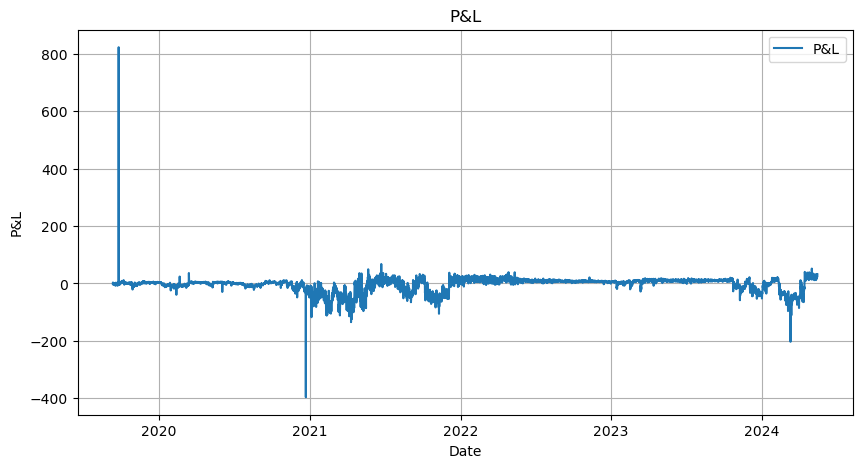

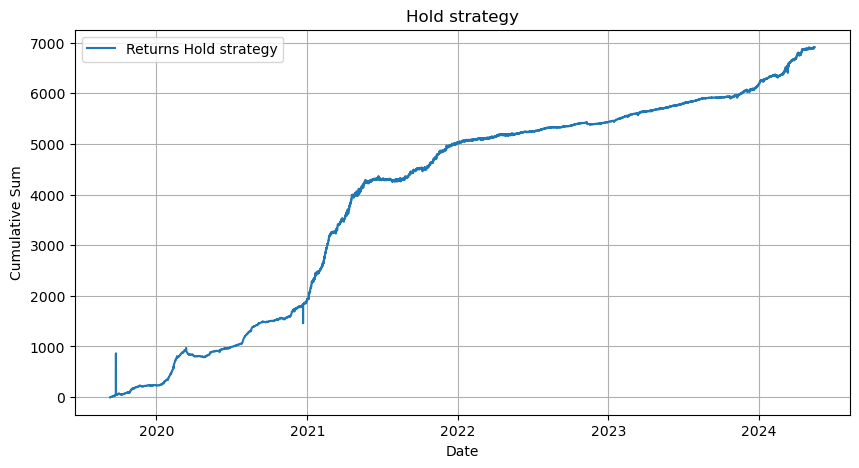

In [187]:
plot_data(data_hold)

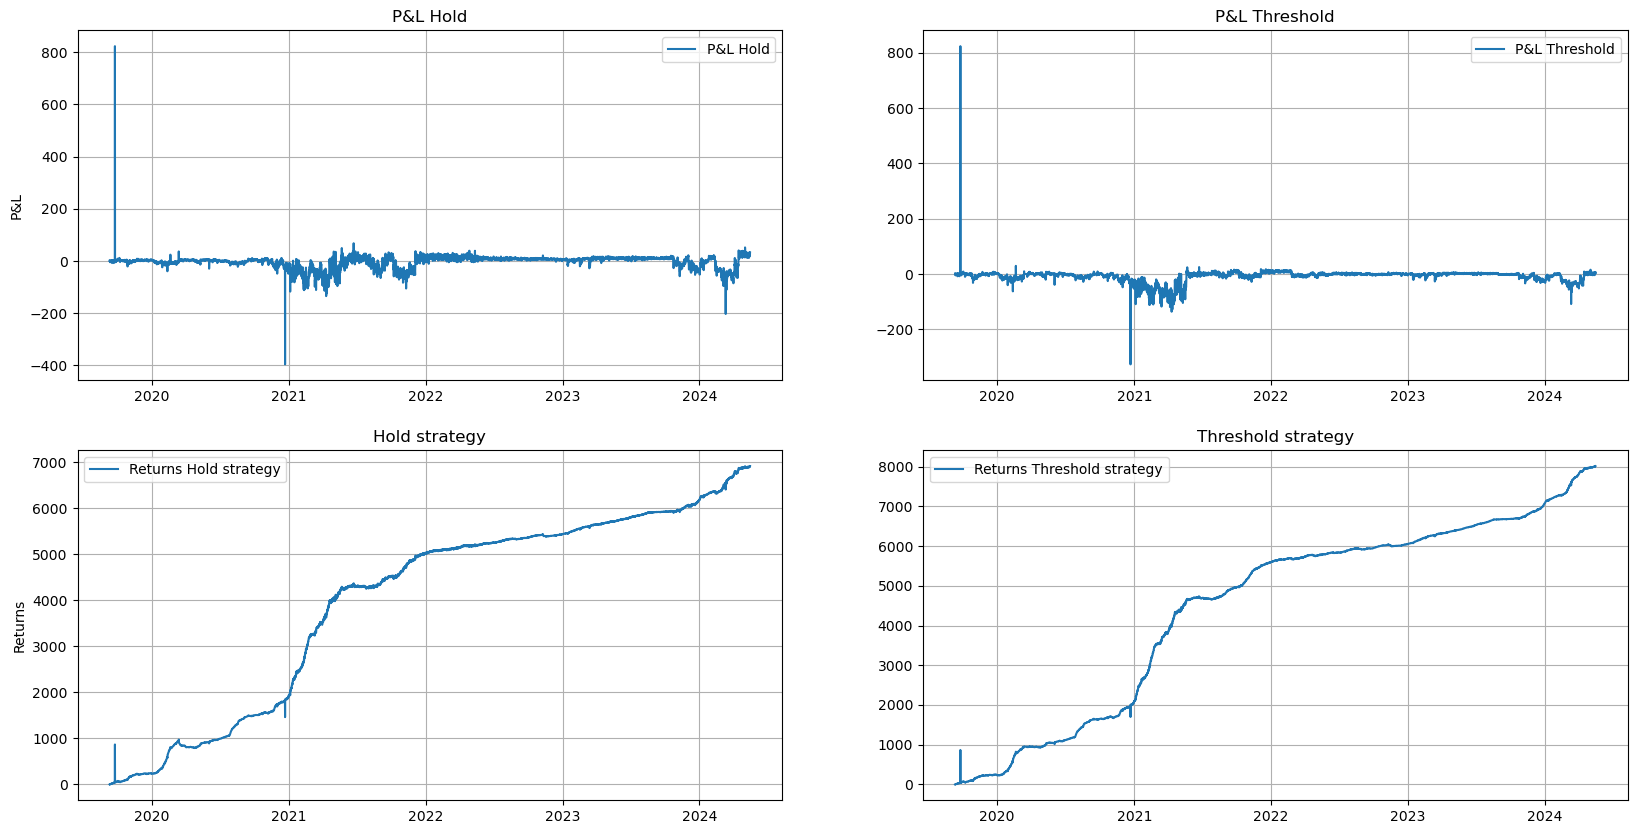

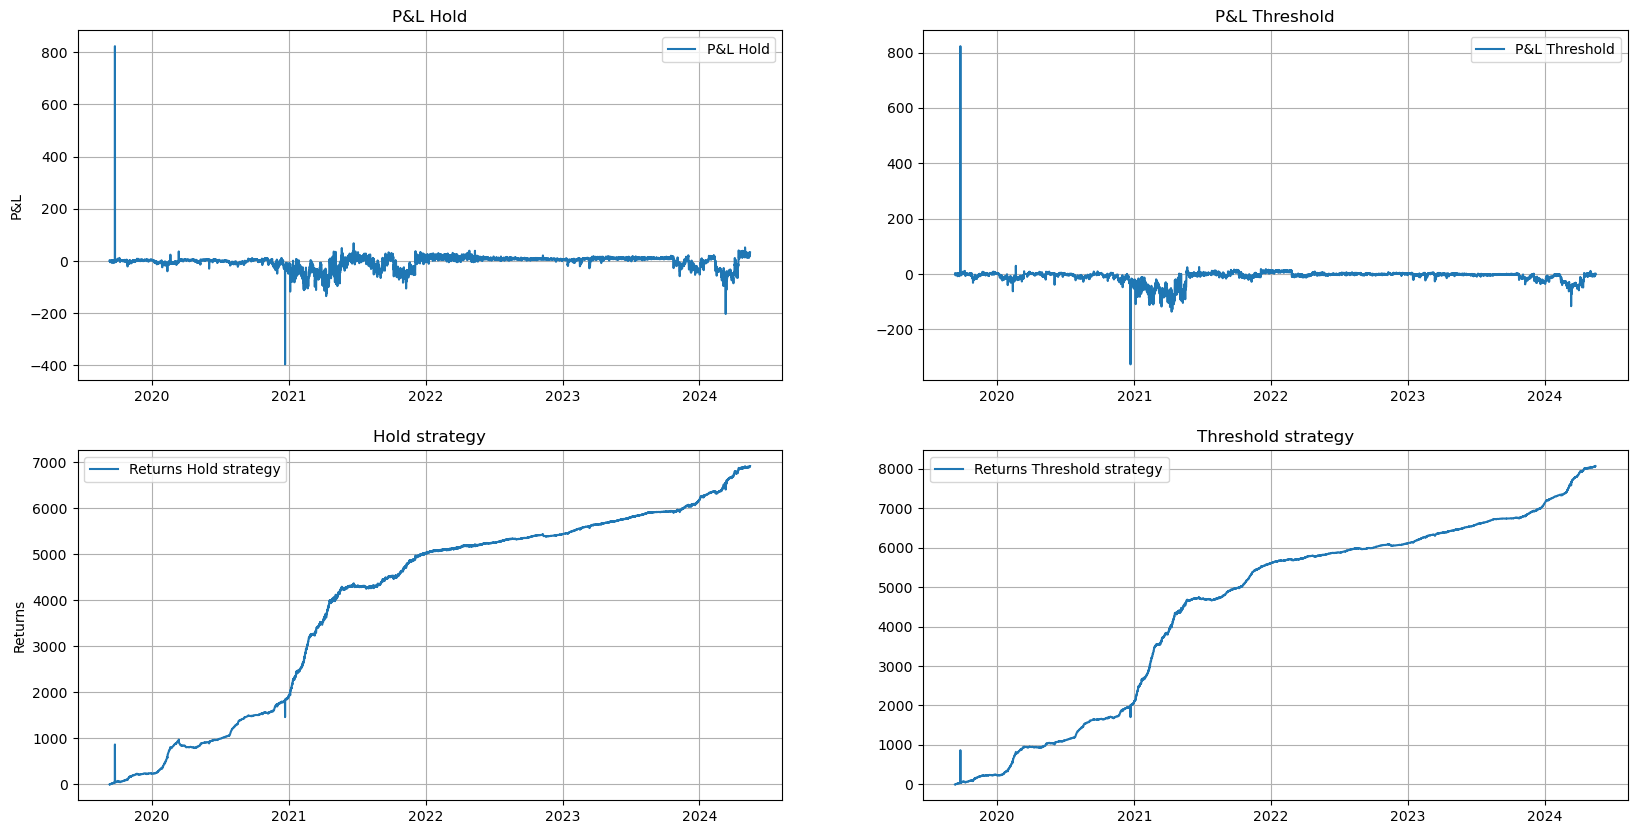

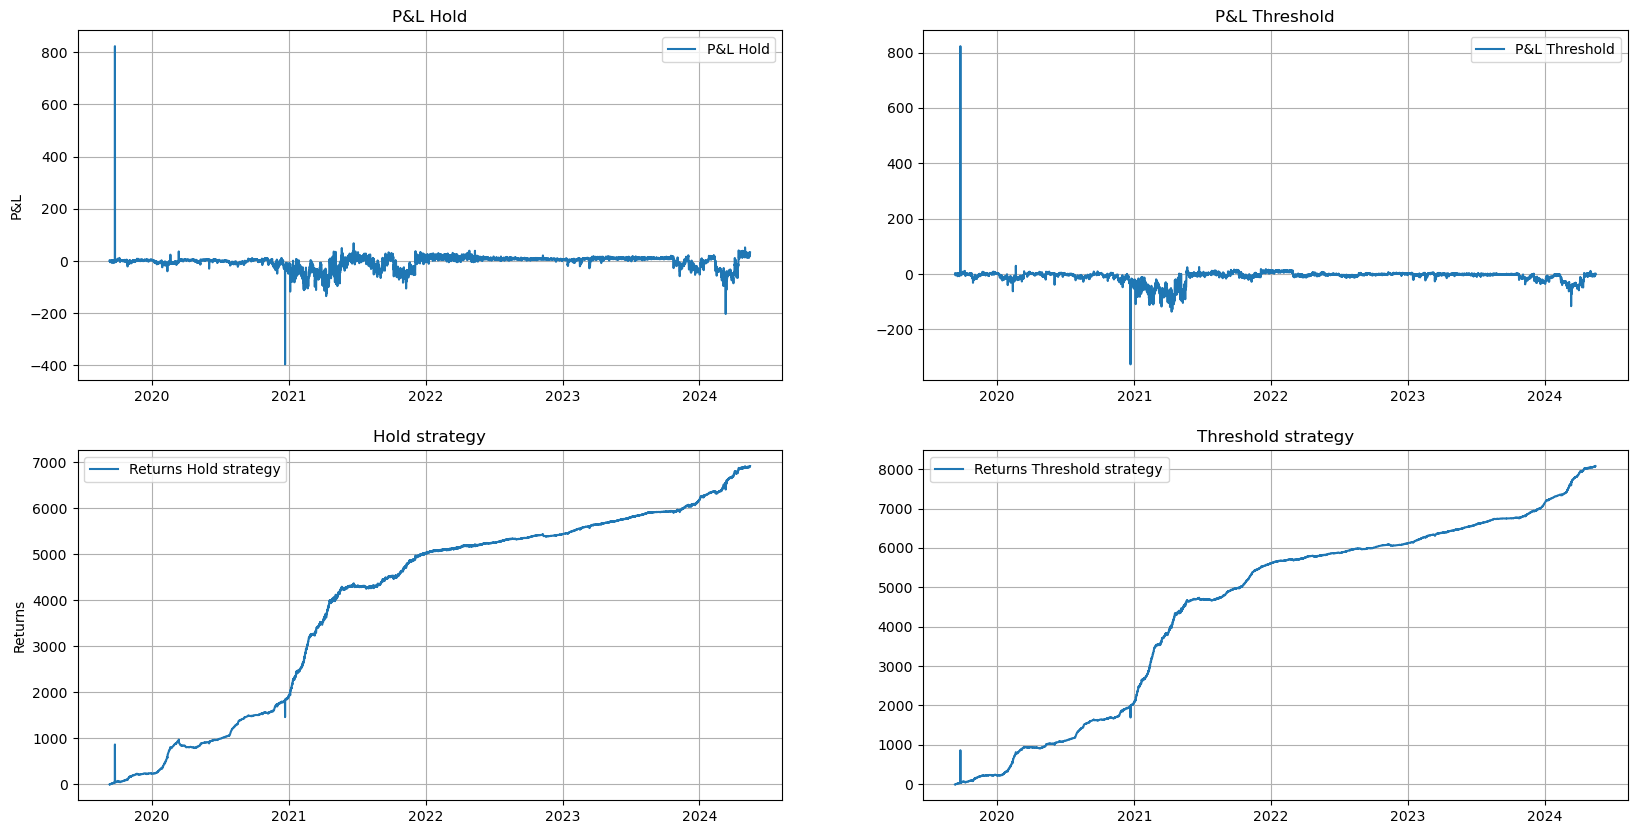

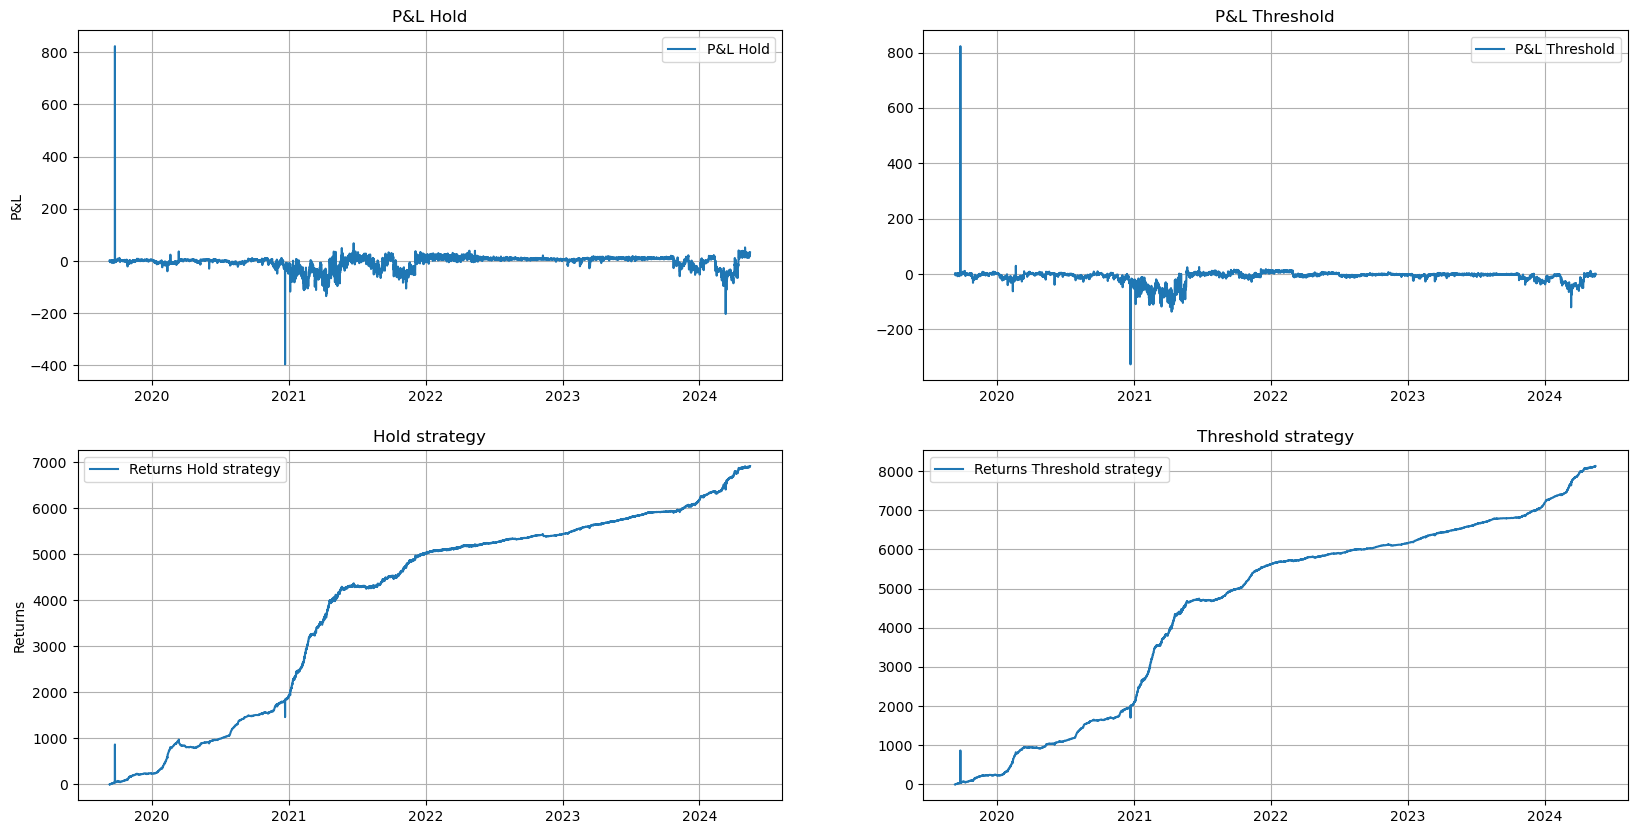

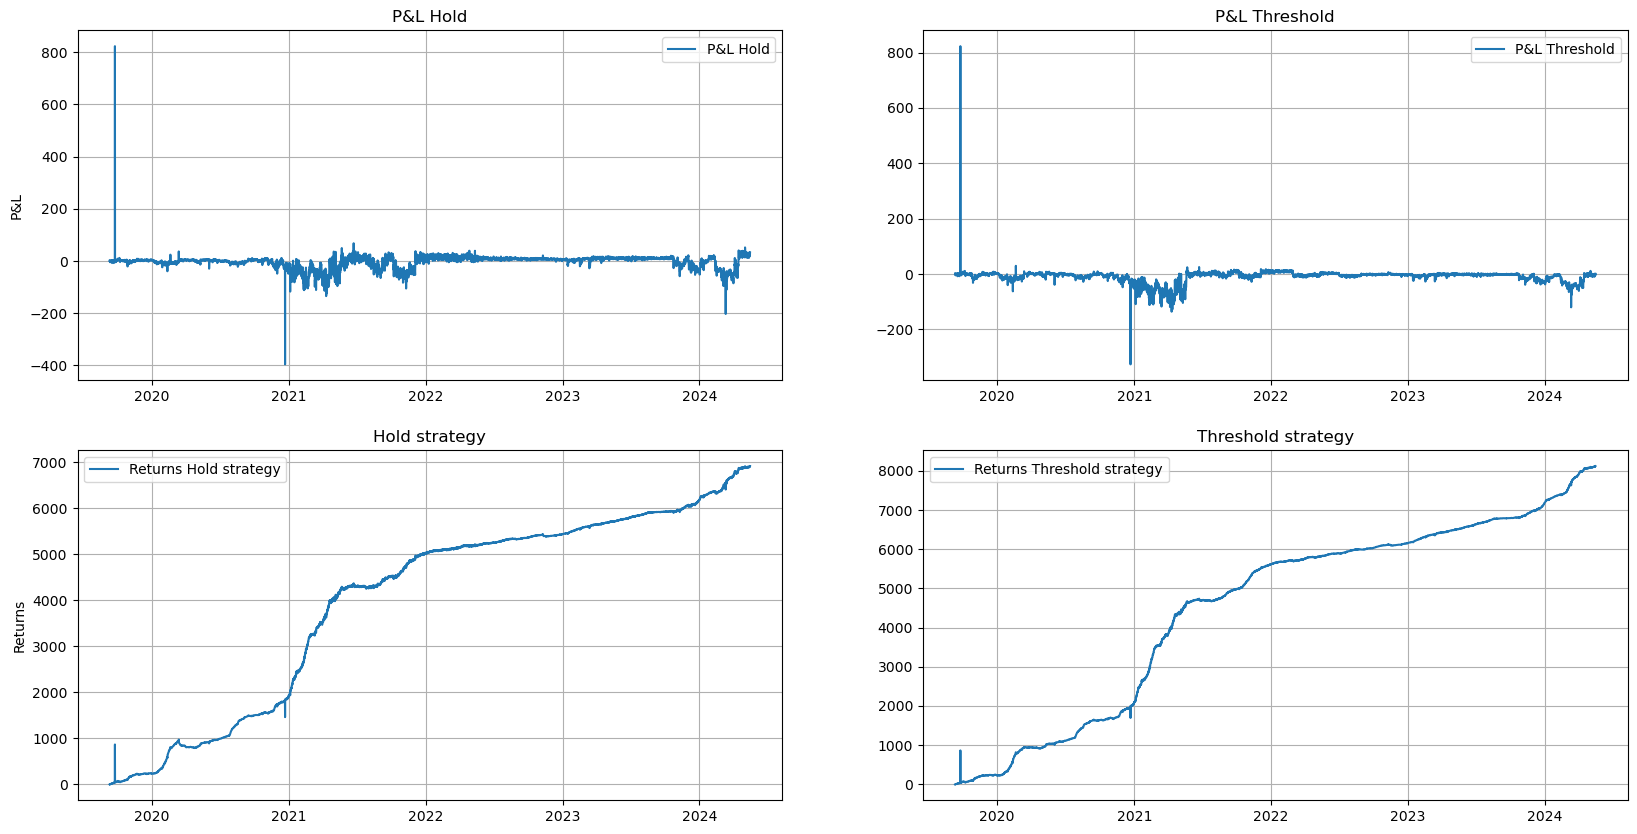

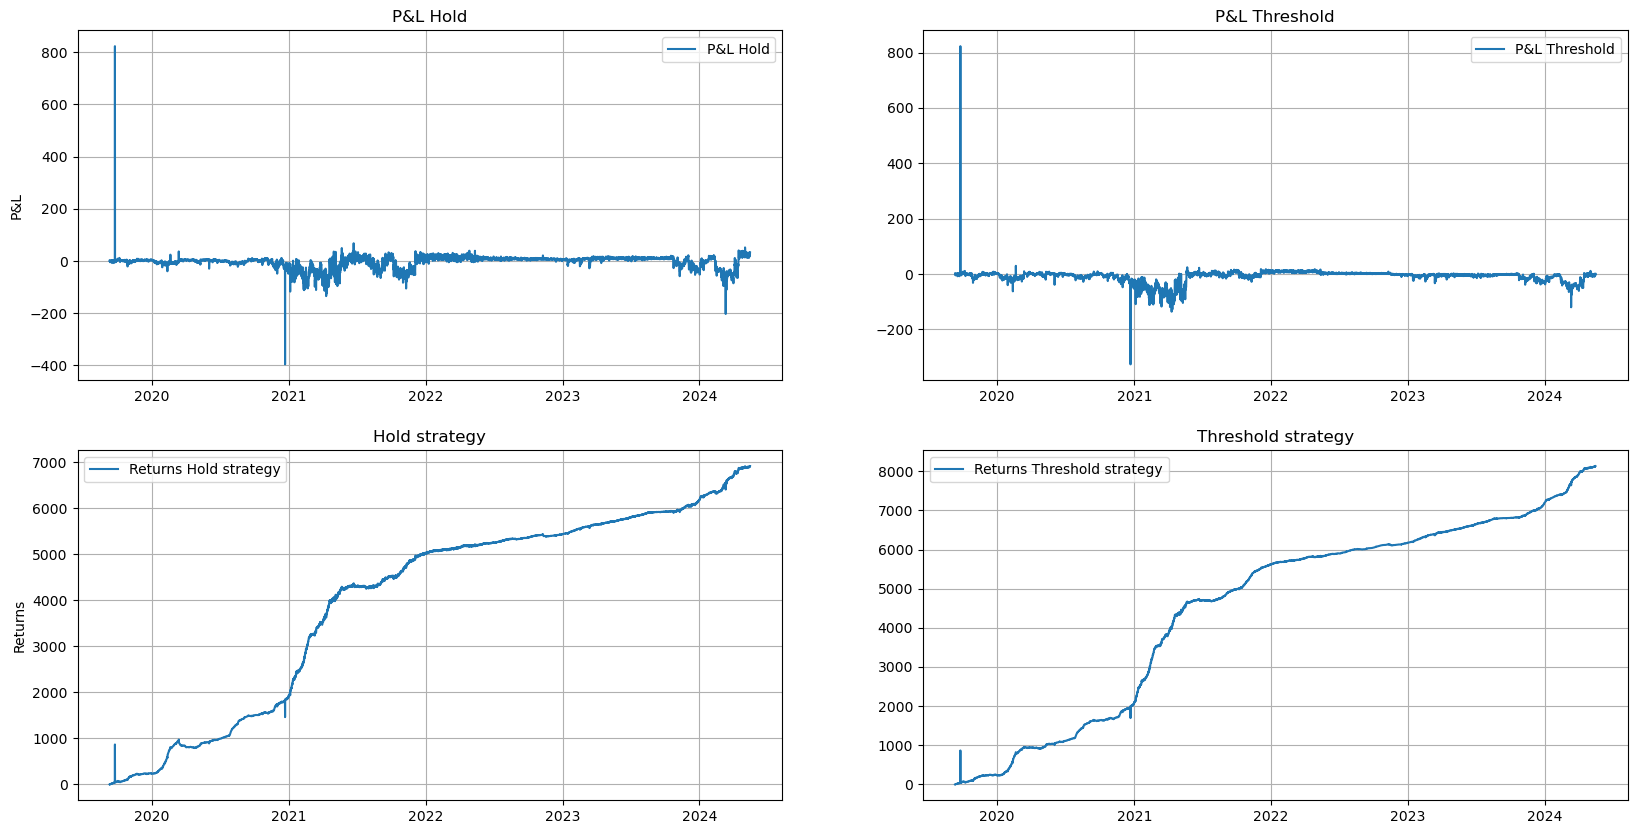

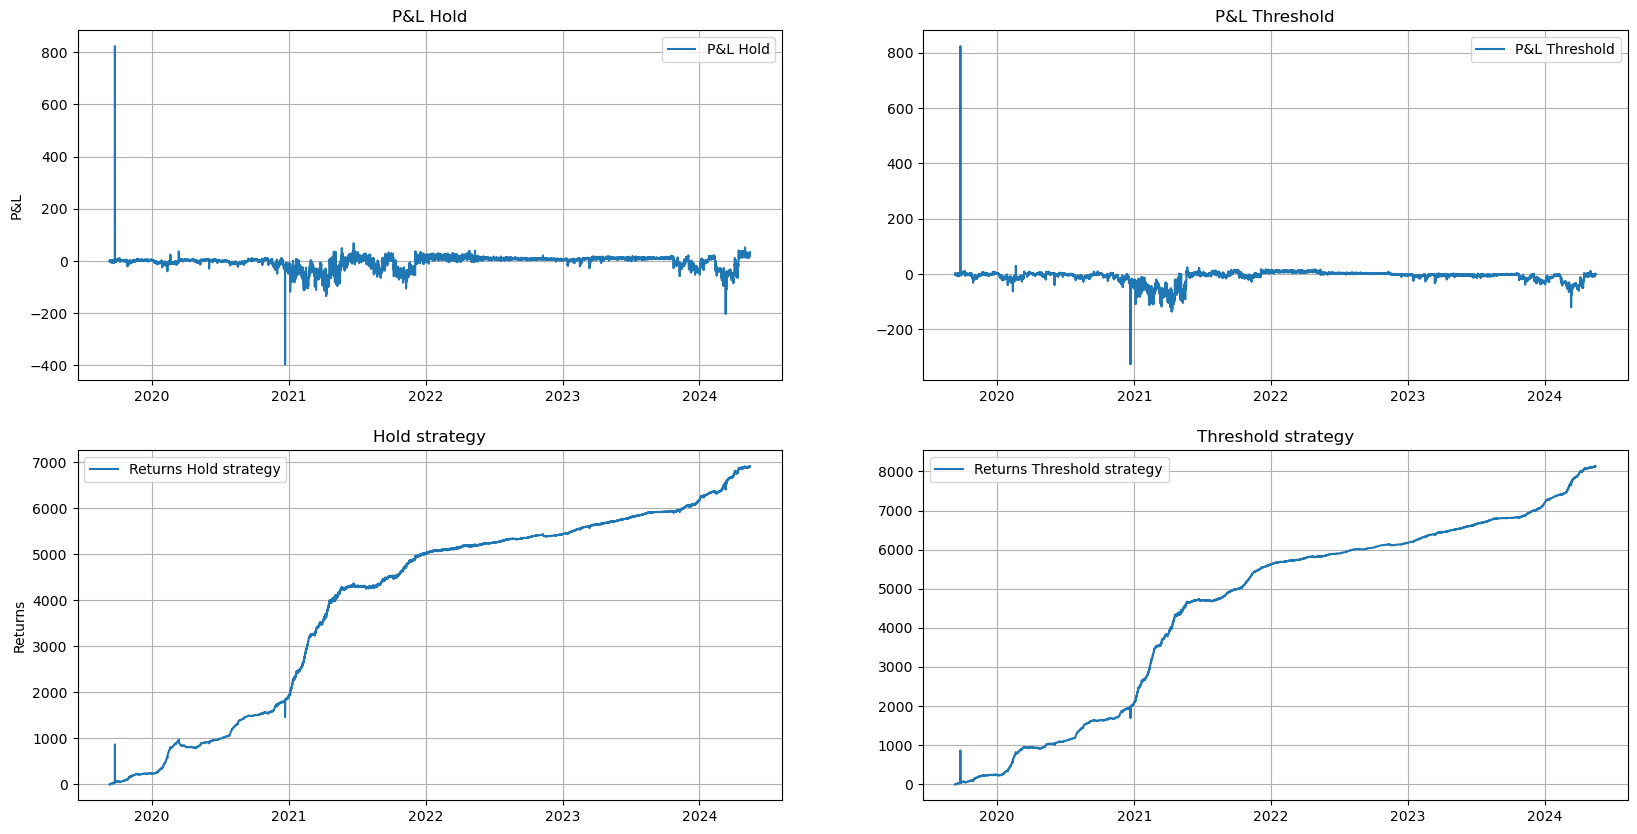

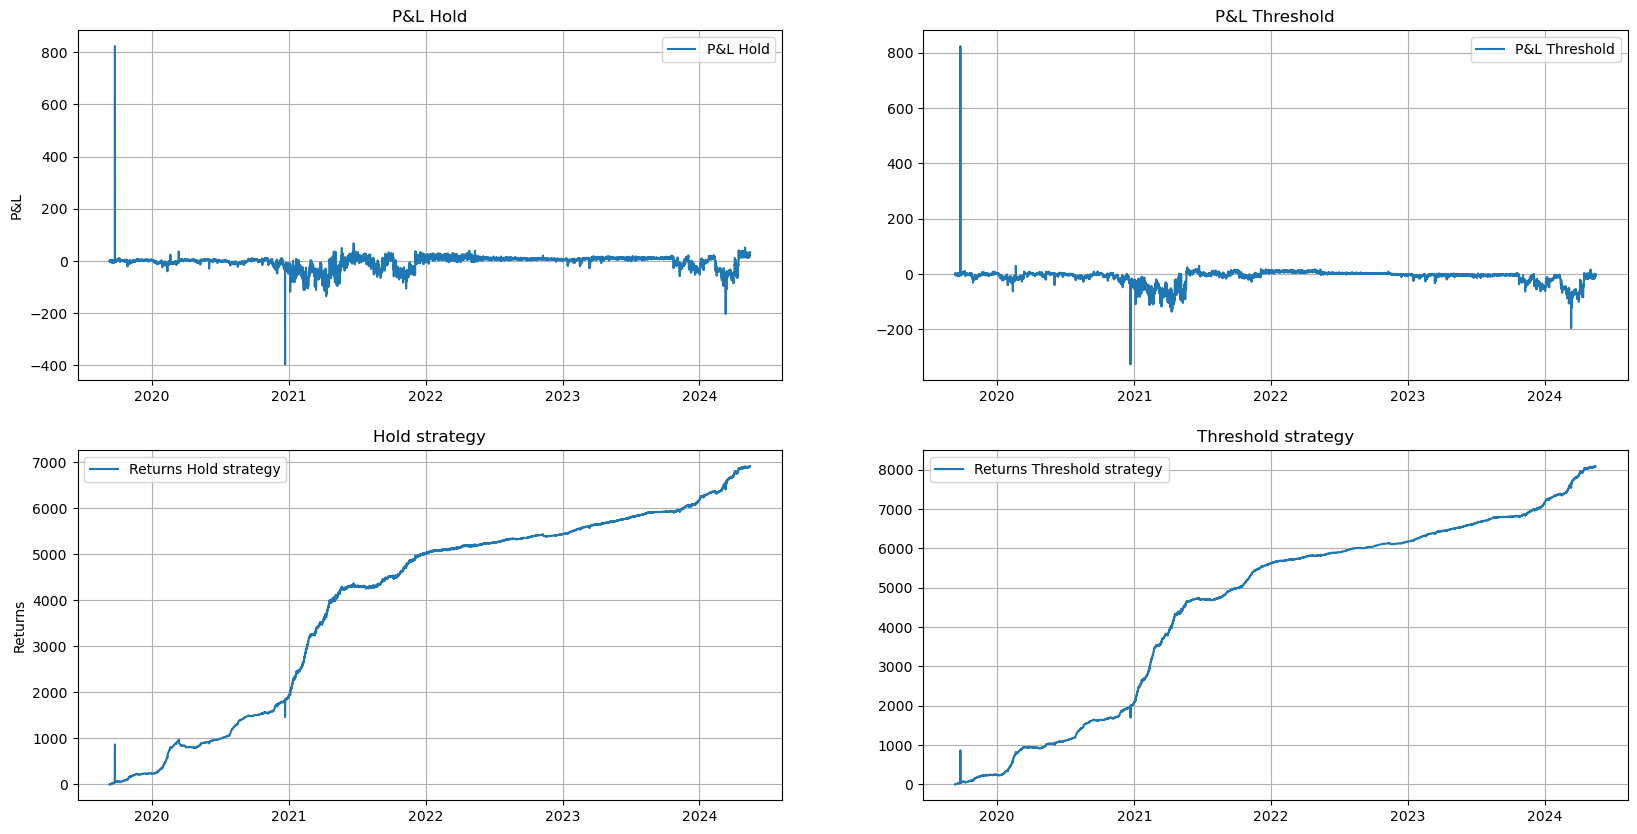

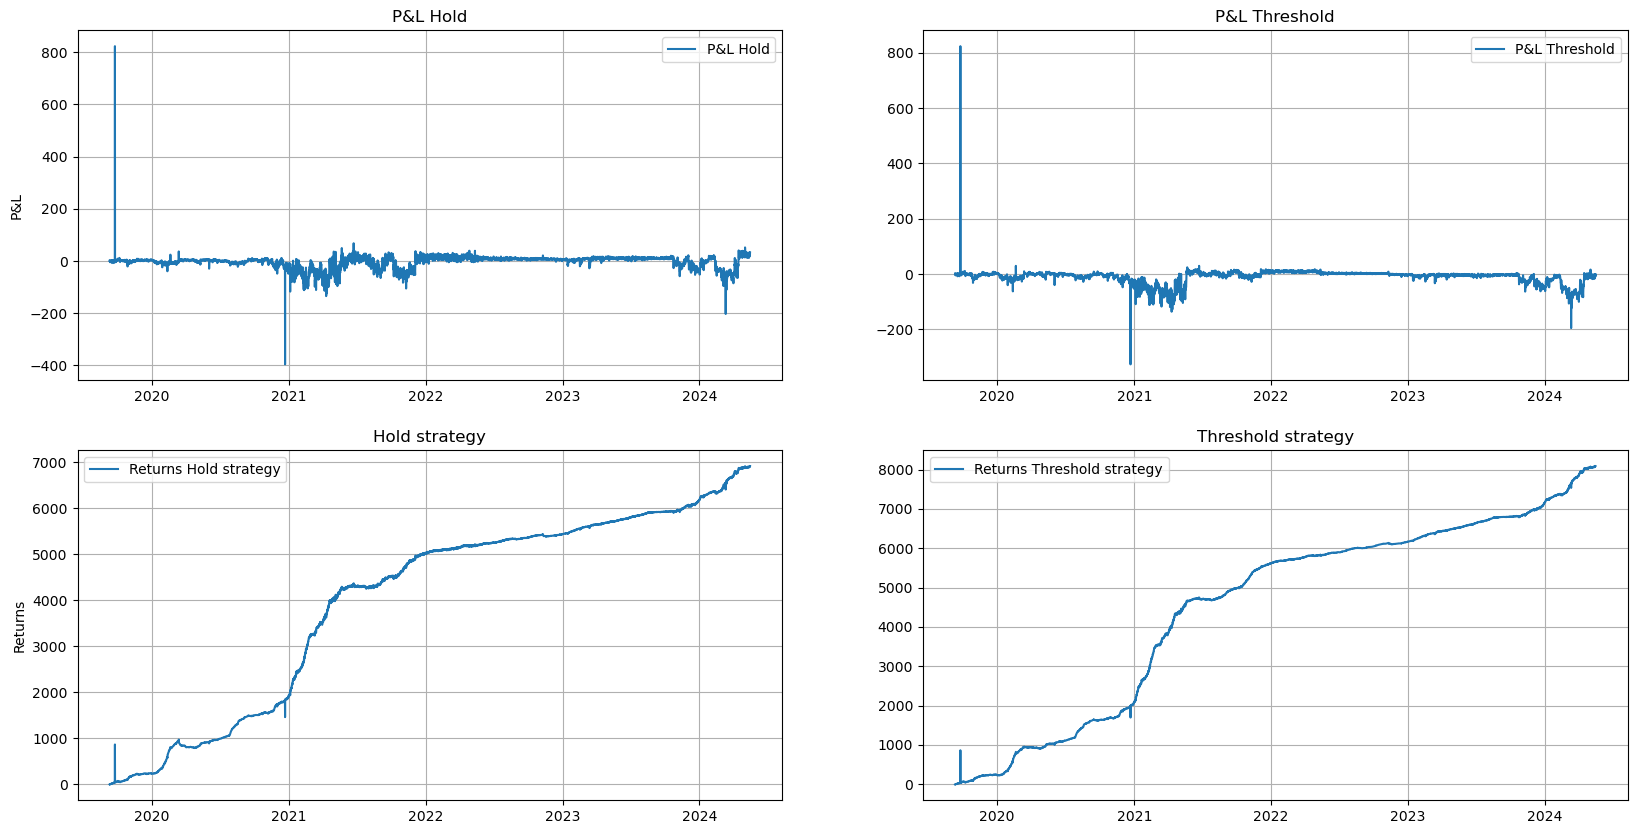

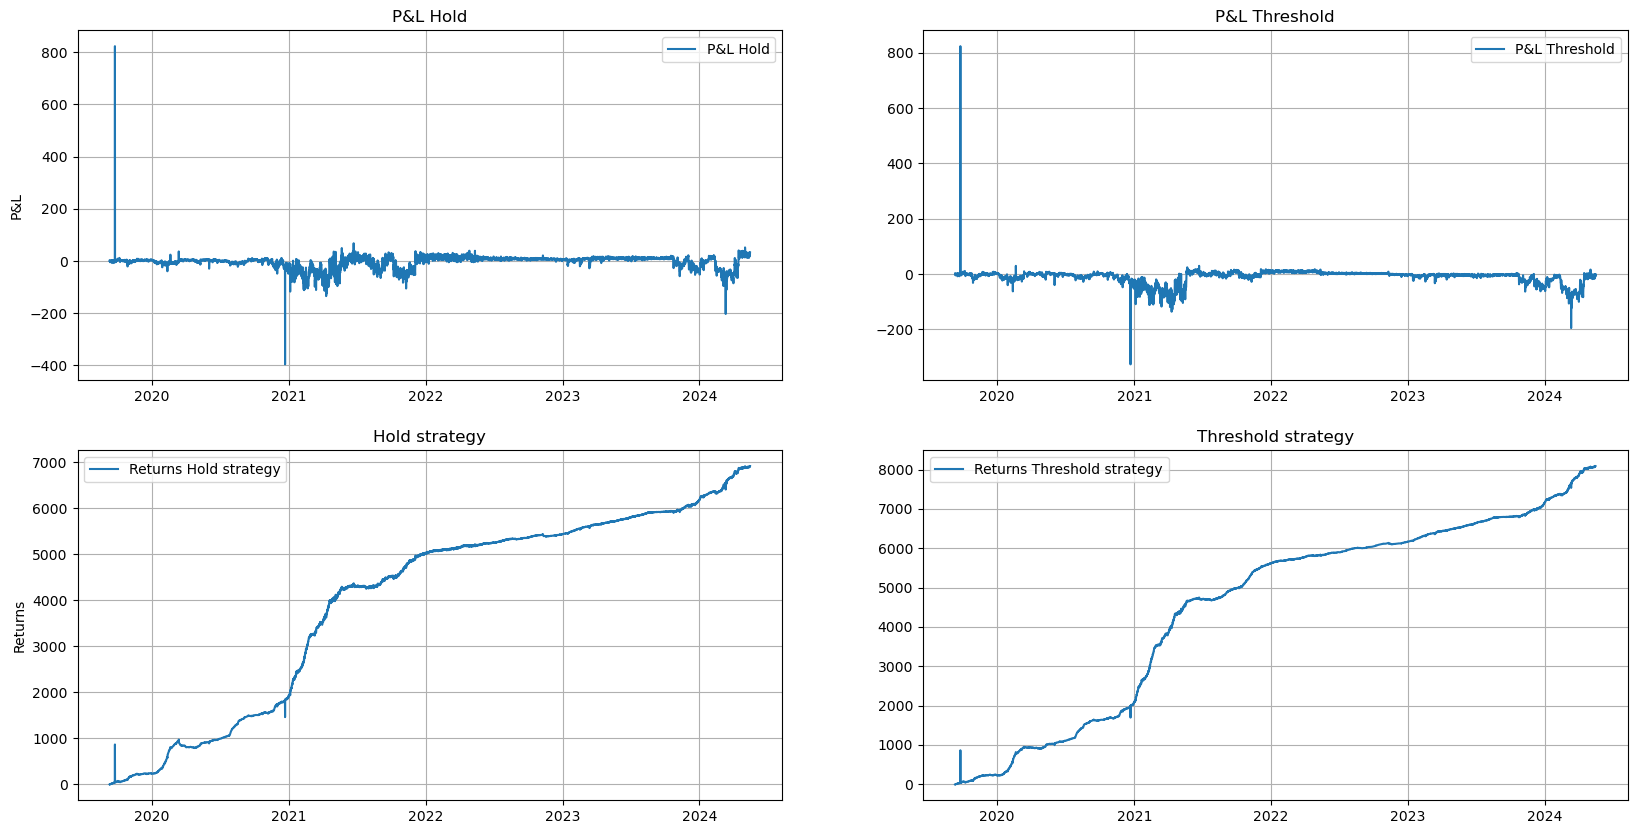

In [188]:
for data_threshold in data_thresholds:
    plot_data_side_by_side(data_hold, data_threshold)

In [189]:
data_hold.describe()

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,3979.992205,-3.658253
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2118.472889,26.047711
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-396.399202
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1564.521159,-8.506322
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5048.994958,3.660401
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,5601.320913,9.357027
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,6908.696313,823.137785


In [190]:
for data_threshold in data_thresholds:
    display(data_threshold.describe())
    print("\n")  # Pour ajouter une ligne vide entre chaque description

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4455.494342,-8.335967
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2409.673215,22.791658
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.384870
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1703.778912,-10.379440
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5640.078153,-1.679255
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6275.441595,1.125055
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8015.235381,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4479.957783,-9.208126
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2428.180444,22.950497
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.696256
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1708.009653,-10.897540
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5648.849312,-2.648328
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6331.317212,0.124922
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8065.958564,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4480.630272,-9.399593
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2434.196785,22.911123
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.708809
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1698.224859,-10.986544
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5650.763419,-2.971200
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6338.741437,0.000000
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8075.449860,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4503.903932,-9.696406
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2450.300839,22.956376
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.638116
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1703.886744,-11.248408
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5664.607214,-3.397899
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6384.496633,0.000000
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8126.827638,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4498.024637,-9.699428
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2448.287844,22.948026
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.532652
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1696.181399,-11.244925
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5656.234222,-3.387872
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6378.454339,0.000000
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8119.207742,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4504.025778,-8.894423
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2453.547218,23.321428
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.517262
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1695.690688,-11.237962
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5659.988043,-2.836287
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6391.592303,1.454369
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8129.718141,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4506.280811,-8.886120
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2454.365399,23.323382
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.473831
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1696.250177,-11.215492
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5662.869348,-2.831038
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6394.635216,1.461608
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8133.144997,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4502.276762,-10.476438
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2448.826310,25.655330
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.452128
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1697.432116,-12.506480
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5662.800575,-3.088853
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6392.435324,1.713096
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8094.069331,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4497.840305,-10.478391
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2445.390873,25.645633
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.365184
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1698.688363,-12.503149
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5657.138350,-3.109386
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6383.877489,1.706029
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8084.425553,823.137785


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate,strat_returns,PandL
count,5133.000000,5133.000000,5133.000000,593.000000,5133.000000,5133.000000,5133.000000
mean,29737.667989,29739.370384,0.000134,51587.244621,0.399144,4496.876167,-10.432045
std,17157.391798,17166.655542,0.000244,12204.929161,0.211888,2446.697932,25.655792
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100,-3.000000,-326.375227
25%,15579.930000,15590.950000,0.000043,41993.000000,0.157246,1697.840566,-12.473967
50%,27546.620000,27533.700000,0.000100,46114.000000,0.504869,5657.357525,-3.026424
75%,42391.510000,42410.400000,0.000100,63883.100000,0.560865,6383.983788,1.730729
max,73224.000000,73280.700000,0.003000,73280.700000,0.689048,8084.267726,823.137785


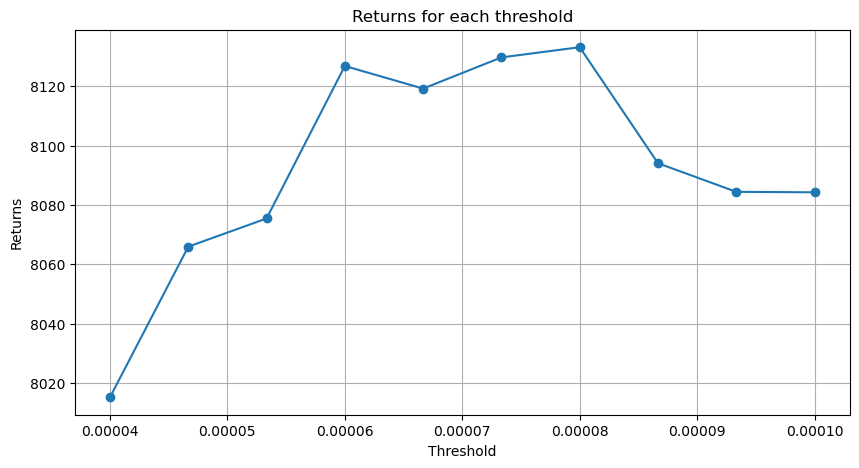

In [191]:
# Plot the max strat_returns for each threshold
max_strat_returns = [data_threshold['strat_returns'].max() for data_threshold in data_thresholds]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, max_strat_returns, marker='o')
plt.title('Returns for each threshold')
plt.xlabel('Threshold')
plt.ylabel('Returns')
plt.grid(True)
plt.show()